# Dense Neural Network Classifier Model using Tensorflow with High Level Estimators.

# 0 - IMPORTS

In [88]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import warnings

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler 

%matplotlib inline
warnings.filterwarnings('ignore')

# 1 - DATA LOAD

In [4]:
df1 = pd.read_csv('..\data\census.csv')
df_shape = df1.shape 
print('Rows: {}\nCols: {}'.format(df_shape[0], df_shape[1]))
df1.head()

Rows: 32561
Cols: 15


,age,workclass,final-weight,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loos,hour-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


# 2 - DATA TRANSFORMATION

In [5]:
df2 = df1.copy()

In [6]:
# change target variable content to 0 or 1
df2['income'] = df2['income'].apply( lambda x: 1 if x==' >50K' else 0)
df2['income'].unique()

array([0, 1], dtype=int64)

# 3 - CREATE TRAIN & TEST DATASET

In [7]:
X = df2.drop('income',axis=1)
y = df2.income

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# 5 - DENSE NEURAL NETWORK CLASSIFIER MODEL

## 5.1 - Create Tensors Categorical Features

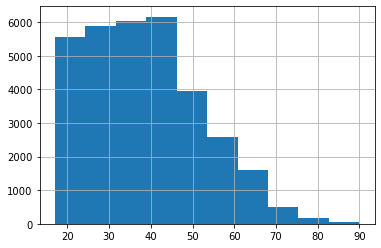

In [9]:
df2.age.hist();

In [39]:
# Create Tensors Variables, using categorical_column_with_hash_bucket, used for large amount of categories

workclass      = tf.feature_column.categorical_column_with_hash_bucket( key = 'workclass',      hash_bucket_size = 100)
education      = tf.feature_column.categorical_column_with_hash_bucket( key = 'education',      hash_bucket_size = 100)
marital_status = tf.feature_column.categorical_column_with_hash_bucket( key = 'marital-status', hash_bucket_size = 100)
occupation     = tf.feature_column.categorical_column_with_hash_bucket( key = 'occupation',     hash_bucket_size = 100)
relationship   = tf.feature_column.categorical_column_with_hash_bucket( key = 'relationship',   hash_bucket_size = 100)
race           = tf.feature_column.categorical_column_with_hash_bucket( key = 'race',           hash_bucket_size = 100)
country        = tf.feature_column.categorical_column_with_hash_bucket( key = 'native-country', hash_bucket_size = 100)

In [40]:
# Create Tensors Variables, using categorical_column_with_hash_bucket, used for small amount of categories
sex = tf.feature_column.categorical_column_with_vocabulary_list( key = 'sex', vocabulary_list = [' Male', ' Female'] )

## 5.2 - Transform Categorical Features to Embedding Columns

In [41]:
workclass_embedding      = tf.feature_column.embedding_column(workclass,      len( df2.workclass.unique() )     )
education_embedding      = tf.feature_column.embedding_column(education,      len( df2.education.unique() )     )
marital_status_embedding = tf.feature_column.embedding_column(marital_status, len( df2['marital-status'].unique() ))
occupation_embedding     = tf.feature_column.embedding_column(occupation,     len( df2.occupation.unique() )    )
relationship_embedding   = tf.feature_column.embedding_column(relationship,   len( df2.relationship.unique() )  )
race_embedding           = tf.feature_column.embedding_column(race,           len( df2.race.unique() )          )
country_embedding        = tf.feature_column.embedding_column(country,        len( df2['native-country'].unique() )       )
sex_embedding            = tf.feature_column.embedding_column(sex,            len( df2.sex.unique() )           )

## 5.3 - Standardized Numeric Features

In [61]:
def age_standard(value):
    return tf.divide( tf.subtract( tf.cast( value, tf.float32 ), tf.constant( df2.age.mean() ) ), tf.constant( df2.age.std() ) ) 

def final_weight_standard(value):
    return tf.divide( tf.subtract( tf.cast( value, tf.float32 ), tf.constant( df2['final-weight'].mean() ) ), tf.constant( df2['final-weight'].std() ) ) 

def education_num_standard(value):
    return tf.divide( tf.subtract( tf.cast( value, tf.float32 ), tf.constant( df2['education-num'].mean() ) ), tf.constant( df2['education-num'].std() ) ) 

def capital_gain_standard(value):
    return tf.divide( tf.subtract( tf.cast( value, tf.float32 ), tf.constant( df2['capital-gain'].mean() ) ), tf.constant( df2['capital-gain'].std() ) ) 

def capital_loos_standard(value):
    return tf.divide( tf.subtract( tf.cast( value, tf.float32 ), tf.constant( df2['capital-loos'].mean() ) ), tf.constant( df2['capital-loos'].std() ) ) 

def hour_standard(value):
    return tf.divide( tf.subtract( tf.cast( value, tf.float32 ), tf.constant( df2['hour-per-week'].mean() ) ), tf.constant( df2['hour-per-week'].std() ) ) 



## 5.4 - Create Tensors Numeric Features

In [63]:
age           = tf.feature_column.numeric_column( key='age',           normalizer_fn = age_standard )
final_weight  = tf.feature_column.numeric_column( key='final-weight',  normalizer_fn = final_weight_standard )
education_num = tf.feature_column.numeric_column( key='education-num', normalizer_fn = education_num_standard )
capital_gain  = tf.feature_column.numeric_column( key='capital-gain',  normalizer_fn = capital_gain_standard )
capital_loos  = tf.feature_column.numeric_column( key='capital-loos',  normalizer_fn = capital_loos_standard )
hour          = tf.feature_column.numeric_column( key='hour-per-week', normalizer_fn = hour_standard )

In [64]:
model_columns = [age, workclass_embedding, final_weight, education_embedding, education_num, marital_status_embedding,
                 occupation_embedding, relationship_embedding, race_embedding, sex_embedding, capital_gain, capital_loos,
                 hour, country_embedding ]

## 5.5 - Create Classifier

In [ ]:
dnn_model = tf.estimator.DNNClassifier(hidden_units=[8, 8], feature_columns=model_columns, n_classes=2)

## 5.6 - Create Train and Test Function 

In [67]:
function_train = tf.estimator.inputs.pandas_input_fn( x=X_train, y=y_train, batch_size=32, num_epochs=None, shuffle=True )

In [68]:
function_test = tf.estimator.inputs.pandas_input_fn( x=X_test, y=y_test, batch_size=32, num_epochs=1000, shuffle=False )

## 5.7 - Model Training

In [ ]:
dnn_model.train( input_fn=function_train, steps=10000 )

## 5.8 - Model Evaluation

In [ ]:
test_metrics = dnn_model.evaluate( input_fn = function_test, steps=10000 )

In [82]:
test_metrics

{'accuracy': 0.8568531,
 'accuracy_baseline': 0.7624781,
 'auc': 0.9131184,
 'auc_precision_recall': 0.7788461,
 'average_loss': 0.307649,
 'label/mean': 0.23752187,
 'loss': 9.844768,
 'precision': 0.75190175,
 'prediction/mean': 0.22649331,
 'recall': 0.592998,
 'global_step': 10000}

# 6 - MODEL PREDICTION

In [74]:
# Create prediction function
function_predict = tf.estimator.inputs.pandas_input_fn( x=X_test, shuffle=False )

In [75]:
y_predict = dnn_model.predict( input_fn = function_predict )

In [ ]:
y_predict_values = []
for p in dnn_model.predict( input_fn = function_predict ):
    y_predict_values.append(p['class_ids'])

In [87]:
acc_score = accuracy_score( y_test, y_predict_values )
acc_score

0.8567918927218753

In [89]:
# Consufion Matrix
cm = confusion_matrix(y_test, y_predict_values)
cm

array([[6995,  454],
       [ 945, 1375]], dtype=int64)